<a href="https://colab.research.google.com/github/kamalchapagain/Kaggle_competition_solutions/blob/master/Kaagle_HousePricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program predicts the prices of house: with advanced regression techniques
credit to Krish C Naik 
https://github.com/krishnaik06/Kaggle-Competitions/blob/master/Advance%20House%20PRice%20PRediction/Final%20Projects%20Kaggle.ipynb

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install --upgrade plotly

     |████████████████████████████████| 13.0MB 311kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
import plotly.express as px

In [299]:
#load the dataset
path='/content/drive/My Drive/GoogleColab/HousePrices/'
train_df=pd.read_csv(path+'train.csv')
test_df=pd.read_csv(path+'test.csv')
sample_submission_df=pd.read_csv(path+'sample_submission.csv')


In [300]:
train_df.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


*seems several NaNs*

In [301]:
test_df.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal


In [260]:
print(train_df.shape, test_df.shape)

(1460, 81) (1459, 80)


# Lets check NaNs 

LotFrontage, Alley, FireplaceQu, and PoolQC constains several NaNs

In [261]:
# #Displaying the columns having only NaNs
# #train_df.isnull().sum()
# null_columns=train_df.columns[train_df.isnull().any()]
# #null_columns
# train_df[null_columns].isnull().sum()

# Construct a function to show the null values

In [302]:
def check_nulls(df):
  sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
  null_columns=df.columns[df.isnull().any()]
  df[null_columns].isnull().sum()
  print(df[null_columns].isnull().sum()) #to display sum of nulls


LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


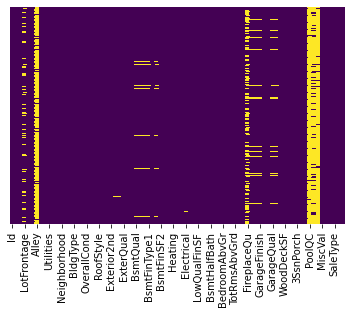

In [303]:
#For training dataset
check_nulls(train_df)

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64


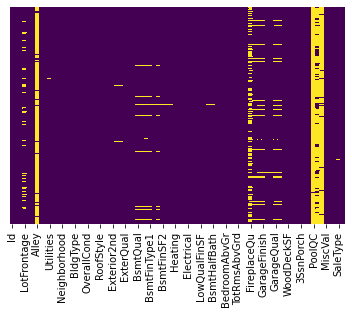

In [304]:
#Similarly for testing dataset,
check_nulls(test_df)

In [305]:
#construction of function to handle the null values

def null_data_management(train_df):
  null_columns=train_df.columns[train_df.isnull().any()] #all the null columns 
  train_df_nans=train_df[null_columns] #(only NaN containing colums in train_df: these columns contains dtypes= cat/int/float)

  #can be check by: train_df_nans.info()

  train_df_nans_cat_features=train_df_nans.select_dtypes(include=['object']).copy()
  train_df_nans_float_features=train_df_nans.select_dtypes(include=['float64']).copy()

  #train_df_nans_cat_features.columns 
  #train_df_nans_float_features.columns
  #train_df_nans_cat_features.isnull().sum() #shows number of NaNs presenting in each columns
  #the meaning of train_df_nans_cat_features.isnull().sum() is same with,
  # train_df[train_df_nans_cat_features.columns].isnull().sum() 

  for i, t in enumerate(train_df_nans_cat_features):            #to replace categorical
    #print(t)
    if train_df[t].isnull().sum()>=100:                         #if more than 100, dropout
      train_df.drop([t],axis=1,inplace=True) 
    else:
      train_df[t]=train_df[t].fillna(train_df[t].mode()[0])     #replace with mode

  for i, t in enumerate(train_df_nans_float_features):          #to replace float
    #print(t)
    if train_df[t].isnull().sum()>=100:
      train_df.drop([t],axis=1,inplace=True) 
    else:
      train_df[t]=train_df[t].fillna(train_df[t].mean())        #replace with mean()
  return train_df



Series([], dtype: float64)


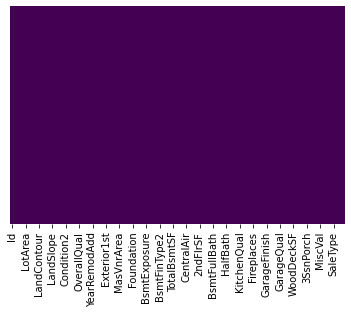

In [306]:
#Lets replace/remove nulls in training data
train_df=null_data_management(train_df)
check_nulls(train_df)

Series([], dtype: float64)


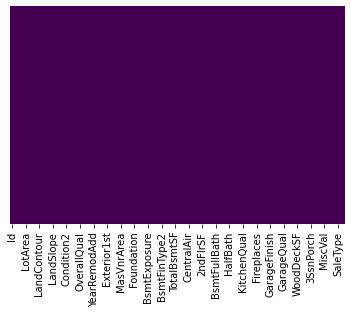

In [307]:
#Lets replace/remove nulls for test data
test_df=null_data_management(test_df)
check_nulls(test_df)

# Part 1 Downcasting

In [268]:
# #Estimate the size before applying memovry saving technique
# train_df_bd = np.round(train_df.memory_usage().sum()/(1024*1024),1)
# test_df_bd = np.round(test_df.memory_usage().sum()/(1024*1024),1)

In [269]:
# #construction of a 'downcast' function in order to save memory
# def downcast(df):
#     cols = df.dtypes.index.tolist()
#     types = df.dtypes.values.tolist()
#     for i,t in enumerate(types):
#         if 'int' in str(t):
#             if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
#                 df[cols[i]] = df[cols[i]].astype(np.int8)
#             elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
#                 df[cols[i]] = df[cols[i]].astype(np.int16)
#             elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
#                 df[cols[i]] = df[cols[i]].astype(np.int32)
#             else:
#                 df[cols[i]] = df[cols[i]].astype(np.int64)
#         elif 'float' in str(t):
#             if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
#                 df[cols[i]] = df[cols[i]].astype(np.float16)
#             elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
#                 df[cols[i]] = df[cols[i]].astype(np.float32)
#             else:
#                 df[cols[i]] = df[cols[i]].astype(np.float64)
#         elif t == np.object:
#             if cols[i] == 'date':
#                 df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
#             else:
#                 df[cols[i]] = df[cols[i]].astype('category')
#     return df  

# train_df = downcast(train_df)
# test_df = downcast(test_df)

In [270]:
# train_df_ad = np.round(train_df.memory_usage().sum()/(1024*1024),1)
# test_df_ad = np.round(test_df.memory_usage().sum()/(1024*1024),1)


In [271]:
# dic = {'DataFrame':['train','test'],
#        'Before downcasting':[train_df_bd, test_df_bd],
#        'After downcasting':[train_df_ad, test_df_ad]}

# memory = pd.DataFrame(dic)
# memory = pd.melt(memory, id_vars='DataFrame', var_name='Status', value_name='Memory (MB)')
# memory.sort_values('Memory (MB)',inplace=True)
# fig = px.bar(memory, x='DataFrame', y='Memory (MB)', color='Status', barmode='group', text='Memory (MB)')
# fig.update_traces(texttemplate='%{text} MB', textposition='outside')
# fig.update_layout(template='seaborn', title='Effect of Downcasting')
# fig.show()

In [308]:
#remove id from both train and testdataset
train_df.drop(['Id'], axis=1, inplace=True)
test_df.drop(['Id'], axis=1, inplace=True)

In [309]:
print(train_df.shape, test_df.shape)

(1460, 74) (1459, 73)


In [332]:
final_df=pd.concat([train_df, test_df], axis=0)

In [333]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2919 non-null   object 
 2   LotArea        2919 non-null   int64  
 3   Street         2919 non-null   object 
 4   LotShape       2919 non-null   object 
 5   LandContour    2919 non-null   object 
 6   Utilities      2919 non-null   object 
 7   LotConfig      2919 non-null   object 
 8   LandSlope      2919 non-null   object 
 9   Neighborhood   2919 non-null   object 
 10  Condition1     2919 non-null   object 
 11  Condition2     2919 non-null   object 
 12  BldgType       2919 non-null   object 
 13  HouseStyle     2919 non-null   object 
 14  OverallQual    2919 non-null   int64  
 15  OverallCond    2919 non-null   int64  
 16  YearBuilt      2919 non-null   int64  
 17  YearRemodAdd   2919 non-null   int64  
 18  RoofStyl

In [336]:
final_cat_columns=final_df.select_dtypes(include=['object']).copy()
multicol=final_cat_columns.columns

In [337]:
len(multicol)

38

In [326]:
# for i, t in enumerate(multcolumns):
#   print(t)

In [327]:
def category_onehot_multcols(multcolumns):
    df_final=final_df
    i=0
    for fields in multcolumns:
        
        #print(fields)
        df1=pd.get_dummies(final_df[fields],drop_first=True)
        
        final_df.drop([fields],axis=1,inplace=True)
        if i==0:
            df_final=df1.copy()
        else:
            
            df_final=pd.concat([df_final,df1],axis=1)
        i=i+1
       
        
    df_final=pd.concat([final_df,df_final],axis=1)
        
    return df_final

In [338]:
df_final=category_onehot_multcols(multcolumns)
df_final.shape

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
SaleType
SaleCondition


(2919, 232)

In [339]:
df_final.shape

(2919, 232)

In [340]:
df_final=df_final.loc[:,~df_final.columns.duplicated()]
df_final.shape

(2919, 176)

In [341]:
df_final.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,FV,RH,RL,RM,...,No,BLQ,GLQ,LwQ,Rec,Unf,GasA,GasW,Grav,OthW,Wall,Y,FuseF,FuseP,Mix,SBrkr,Maj2,Min1,Min2,Typ,Attchd,Basment,BuiltIn,CarPort,Detchd,RFn,P,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
0,60,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008,208500.0,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,20,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007,181500.0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,60,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008,223500.0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,70,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006,140000.0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,60,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008,250000.0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [344]:
train_shape=train_df.shape[0]

1460

In [346]:
train_df=df_final.iloc[:train_df.shape[0],:]
test_df=df_final.iloc[train_df.shape[0]:,:]

In [350]:
test_df.drop(['SalePrice'], axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [351]:
test_df.shape

(1459, 175)

In [352]:
##manage train/test
X_train=train_df.drop(['SalePrice'], axis=1)
y_train=train_df['SalePrice']


In [354]:
import xgboost
classifier=xgboost.XGBRegressor()
classifier.fit(X_train, y_train)

[20:33:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [355]:
import pickle
filename='trained_model.pkl'
pickle.dump(classifier, open(filename, 'wb') )

In [359]:
y_pred=classifier.predict(test_df)

In [360]:
y_pred

array([121496.04, 155361.03, 176559.39, ..., 173472.31, 120005.4 ,
       238486.1 ], dtype=float32)

In [362]:
##Create Sample Submission
pred=pd.DataFrame(y_pred)
datasets=pd.concat([sample_submission_df['Id'],pred], axis=1)
datasets.columns=['Id', 'SalePrice']
datasets

,Id,SalePrice
0,1461,121496.039062
1,1462,155361.031250
2,1463,176559.390625
3,1464,178720.640625
4,1465,192541.640625
...,...,...
1454,2915,86552.593750
1455,2916,88596.195312
1456,2917,173472.312500
1457,2918,120005.398438
